# Using CNN's with the Cats and Dogs Dataset for image classification

This notebook demonstrates an image classification project using the popular Cats vs Dogs dataset. The goal is to build a Convolutional Neural Network (CNN) from scratch using TensorFlow and Keras to classify whether an image contains a cat or a dog.

In this project, I apply various image preprocessing techniques and create helper functions to manage image directories efficiently using Python's os module. The model is trained, evaluated, and visualized to assess its performance.

In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

## Download the dataset

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2025-07-20 12:54:39--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.218.186.12, 2600:1409:3c00:c80::317f, 2600:1409:3c00:c8c::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.218.186.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  83.5MB/s    in 8.4s    

2025-07-20 12:54:47 (93.3 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



## orginize the dataset

In [3]:
# grader-required-cell
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


To organize the dataset properly, I created a directory structure for the Cats vs Dogs classification task. The main directory cats-v-dogs contains separate folders for training and validation data. Each of these folders has two subdirectories: one for cats and one for dogs.

The create_train_val_dirs function below is used to automate the creation of this structure.

In [4]:
root_dir = '/tmp/cats-v-dogs'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
  # Create 'training' subdirectories
  os.makedirs(os.path.join(root_path, 'training'))
  os.makedirs(os.path.join(f'{root_path}/training', 'cats'))
  os.makedirs(os.path.join(f'{root_path}/training', 'dogs'))
  # Create 'testing' subdirectories
  os.makedirs(os.path.join(root_path, 'validation'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'cats'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'dogs'))

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("Directory already exists. Skipping creation.")

In [5]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs


The split_data function splits image files from a source directory into training and validation sets based on a specified split size.
It filters out zero-length files, shuffles the remaining ones, then copies them into the target directories for training and validation.

In [6]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE_DIR):
        file_name = os.path.join(SOURCE_DIR, filename)
        if os.path.getsize(file_name) > 0:
            files.append(filename)
        else:
            print("{} has zero length so discarding".format(filename))
  train_set_size = int(len(files)*SPLIT_SIZE)
  shuffled_data = random.sample(files, len(files))
  training_data = shuffled_data[0:train_set_size]
  validation_data = shuffled_data[train_set_size:len(files)]

  for file in training_data:
        src_file = os.path.join(SOURCE_DIR, file)
        des_file = os.path.join(TRAINING_DIR, file)
        copyfile(src_file, des_file)

  for file in validation_data:
        src_file = os.path.join(SOURCE_DIR, file)
        des_file = os.path.join(VALIDATION_DIR, file)
        copyfile(src_file, des_file)

In [7]:
# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case this cell running multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg has zero length so discarding
11702.jpg has zero length so discarding


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


## Preparing Image Generators

Now that the data is properly organized, we can create image generators using Keras’ ImageDataGenerator.
These generators will read images from the directory structure and yield batches of preprocessed images for both training and validation.

Note: Since the images have varying resolutions, we'll use the target_size parameter in flow_from_directory to resize them to 150×150 pixels.

In [8]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator

In [9]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Defining and Compiling the Model

Before training, we need to define the architecture of the convolutional neural network (CNN) using Keras’ Sequential API.
The model will be compiled with a loss function that matches the output shape and the class_mode used in the data generators.

In [11]:
from tensorflow.keras.optimizers import RMSprop

def create_model2():
  model = tf.keras.models.Sequential([
      #first convulation
      tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      #second convulation
      tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      #third convulation
      tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      #four convulation
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      #dropout
      tf.keras.layers.Dropout(0.5),
      #flatten
      tf.keras.layers.Flatten(),
      #dense
      tf.keras.layers.Dense(512, activation = 'relu'),
      tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])


  model.compile(optimizer=RMSprop(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

## Training model

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model2 = create_model2()

history = model2.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
  97/1125 ━━━━━━━━━━━━━━━━━━━━ 2:52 167ms/step - accuracy: 0.5160 - loss: 0.6961

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 160s 138ms/step - accuracy: 0.5675 - loss: 0.6727 - val_accuracy: 0.6680 - val_loss: 0.6046
Epoch 2/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 149s 133ms/step - accuracy: 0.6870 - loss: 0.5814 - val_accuracy: 0.7024 - val_loss: 0.5533
Epoch 3/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 150s 133ms/step - accuracy: 0.7215 - loss: 0.5415 - val_accuracy: 0.7664 - val_loss: 0.4819
Epoch 4/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 148s 132ms/step - accuracy: 0.7466 - loss: 0.5129 - val_accuracy: 0.7760 - val_loss: 0.4651
Epoch 5/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 151s 134ms/step - accuracy: 0.7730 - loss: 0.4787 - val_accuracy: 0.8076 - val_loss: 0.4357
Epoch 6/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 150s 133ms/step - accuracy: 0.7822 - loss: 0.4597 - val_accuracy: 0.7928 - val_loss: 0.4647
Epoch 7/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 150s 133ms/step - accuracy: 0.7998 - loss: 0.4336 - val_accuracy: 0.8352 - val_loss: 0.3707
Epoch 8/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 149s 133ms/step - accuracy: 0.8

## Validation

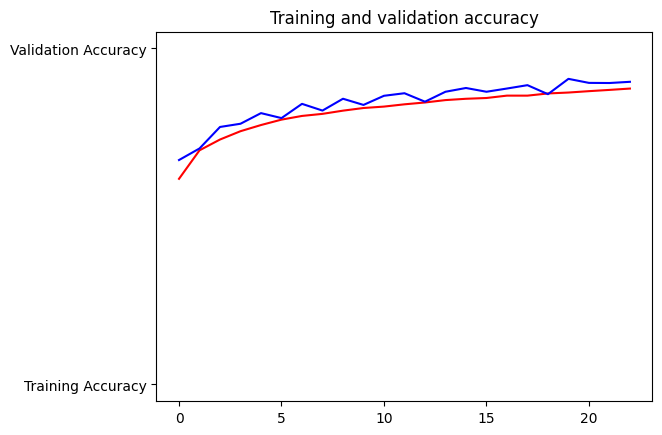

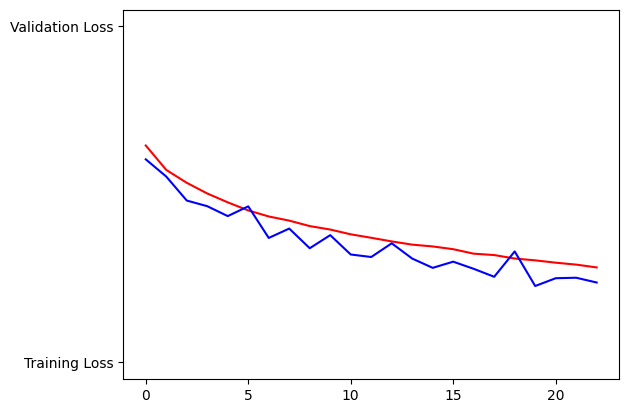

In [13]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


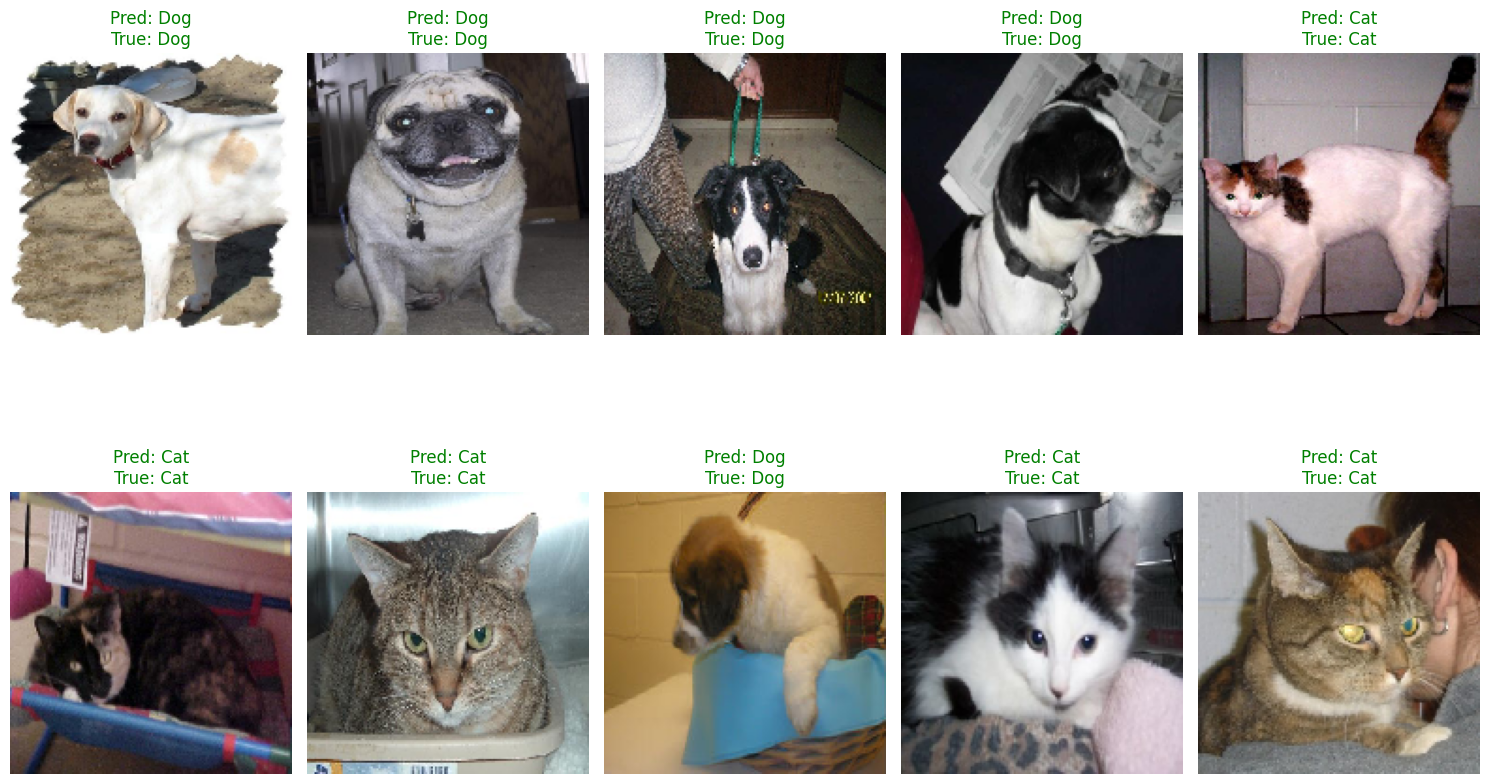

In [16]:
import numpy as np

validation_generator.reset()
class_names = list(validation_generator.class_indices.keys())

images, labels = next(validation_generator)

predictions = model2.predict(images)

plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    pred_label = "Dog" if predictions[i] > 0.5 else "Cat"
    true_label = "Dog" if labels[i] > 0.5 else "Cat"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='green' if pred_label==true_label else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


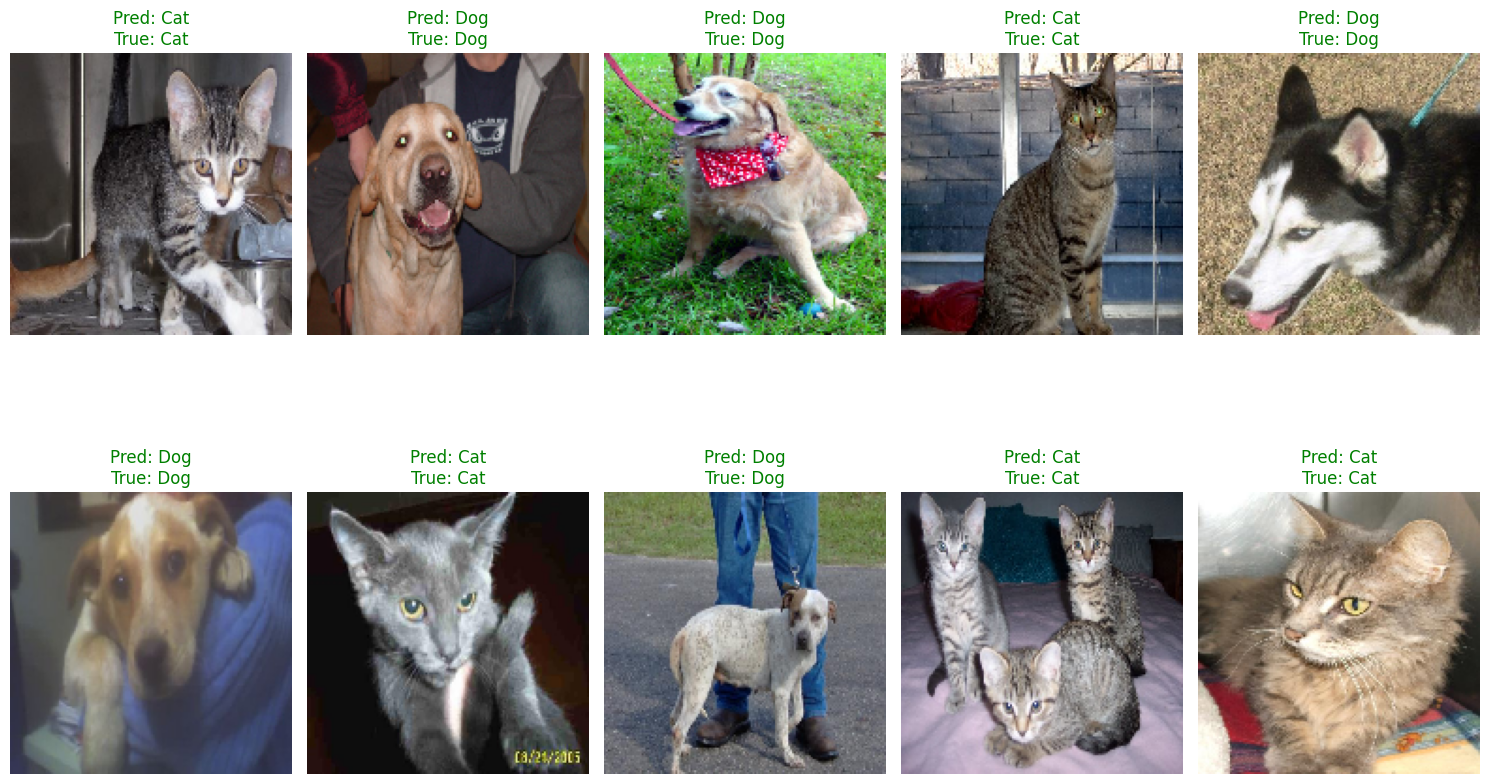

In [17]:
validation_generator.reset()
class_names = list(validation_generator.class_indices.keys())

images, labels = next(validation_generator)

predictions = model2.predict(images)

plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    pred_label = "Dog" if predictions[i] > 0.5 else "Cat"
    true_label = "Dog" if labels[i] > 0.5 else "Cat"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='green' if pred_label==true_label else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()